# Preparation

In [0]:
# Install TF docs
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
#@title Import statements

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

2.2.0-rc2


In [0]:
#@title (Misc) GDrive integration
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Read dataset from CSV file

In [0]:
url = 'https://raw.githubusercontent.com/imiro/bangkit-w05-winequality/master/datasets/winequality-red.csv'
df = pd.read_csv(url)

# Dataset characteristics

In [0]:
#@title Import plotting functions

import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
from collections import Counter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


Here we explore what our dataset has to offer.

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [0]:
df.shape

(1599, 12)

In [0]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [0]:
df['quality'].value_counts(sort=False)

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

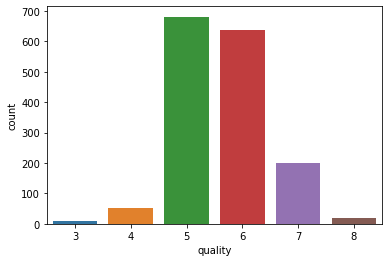

In [0]:
sns.countplot(x='quality', data=df)

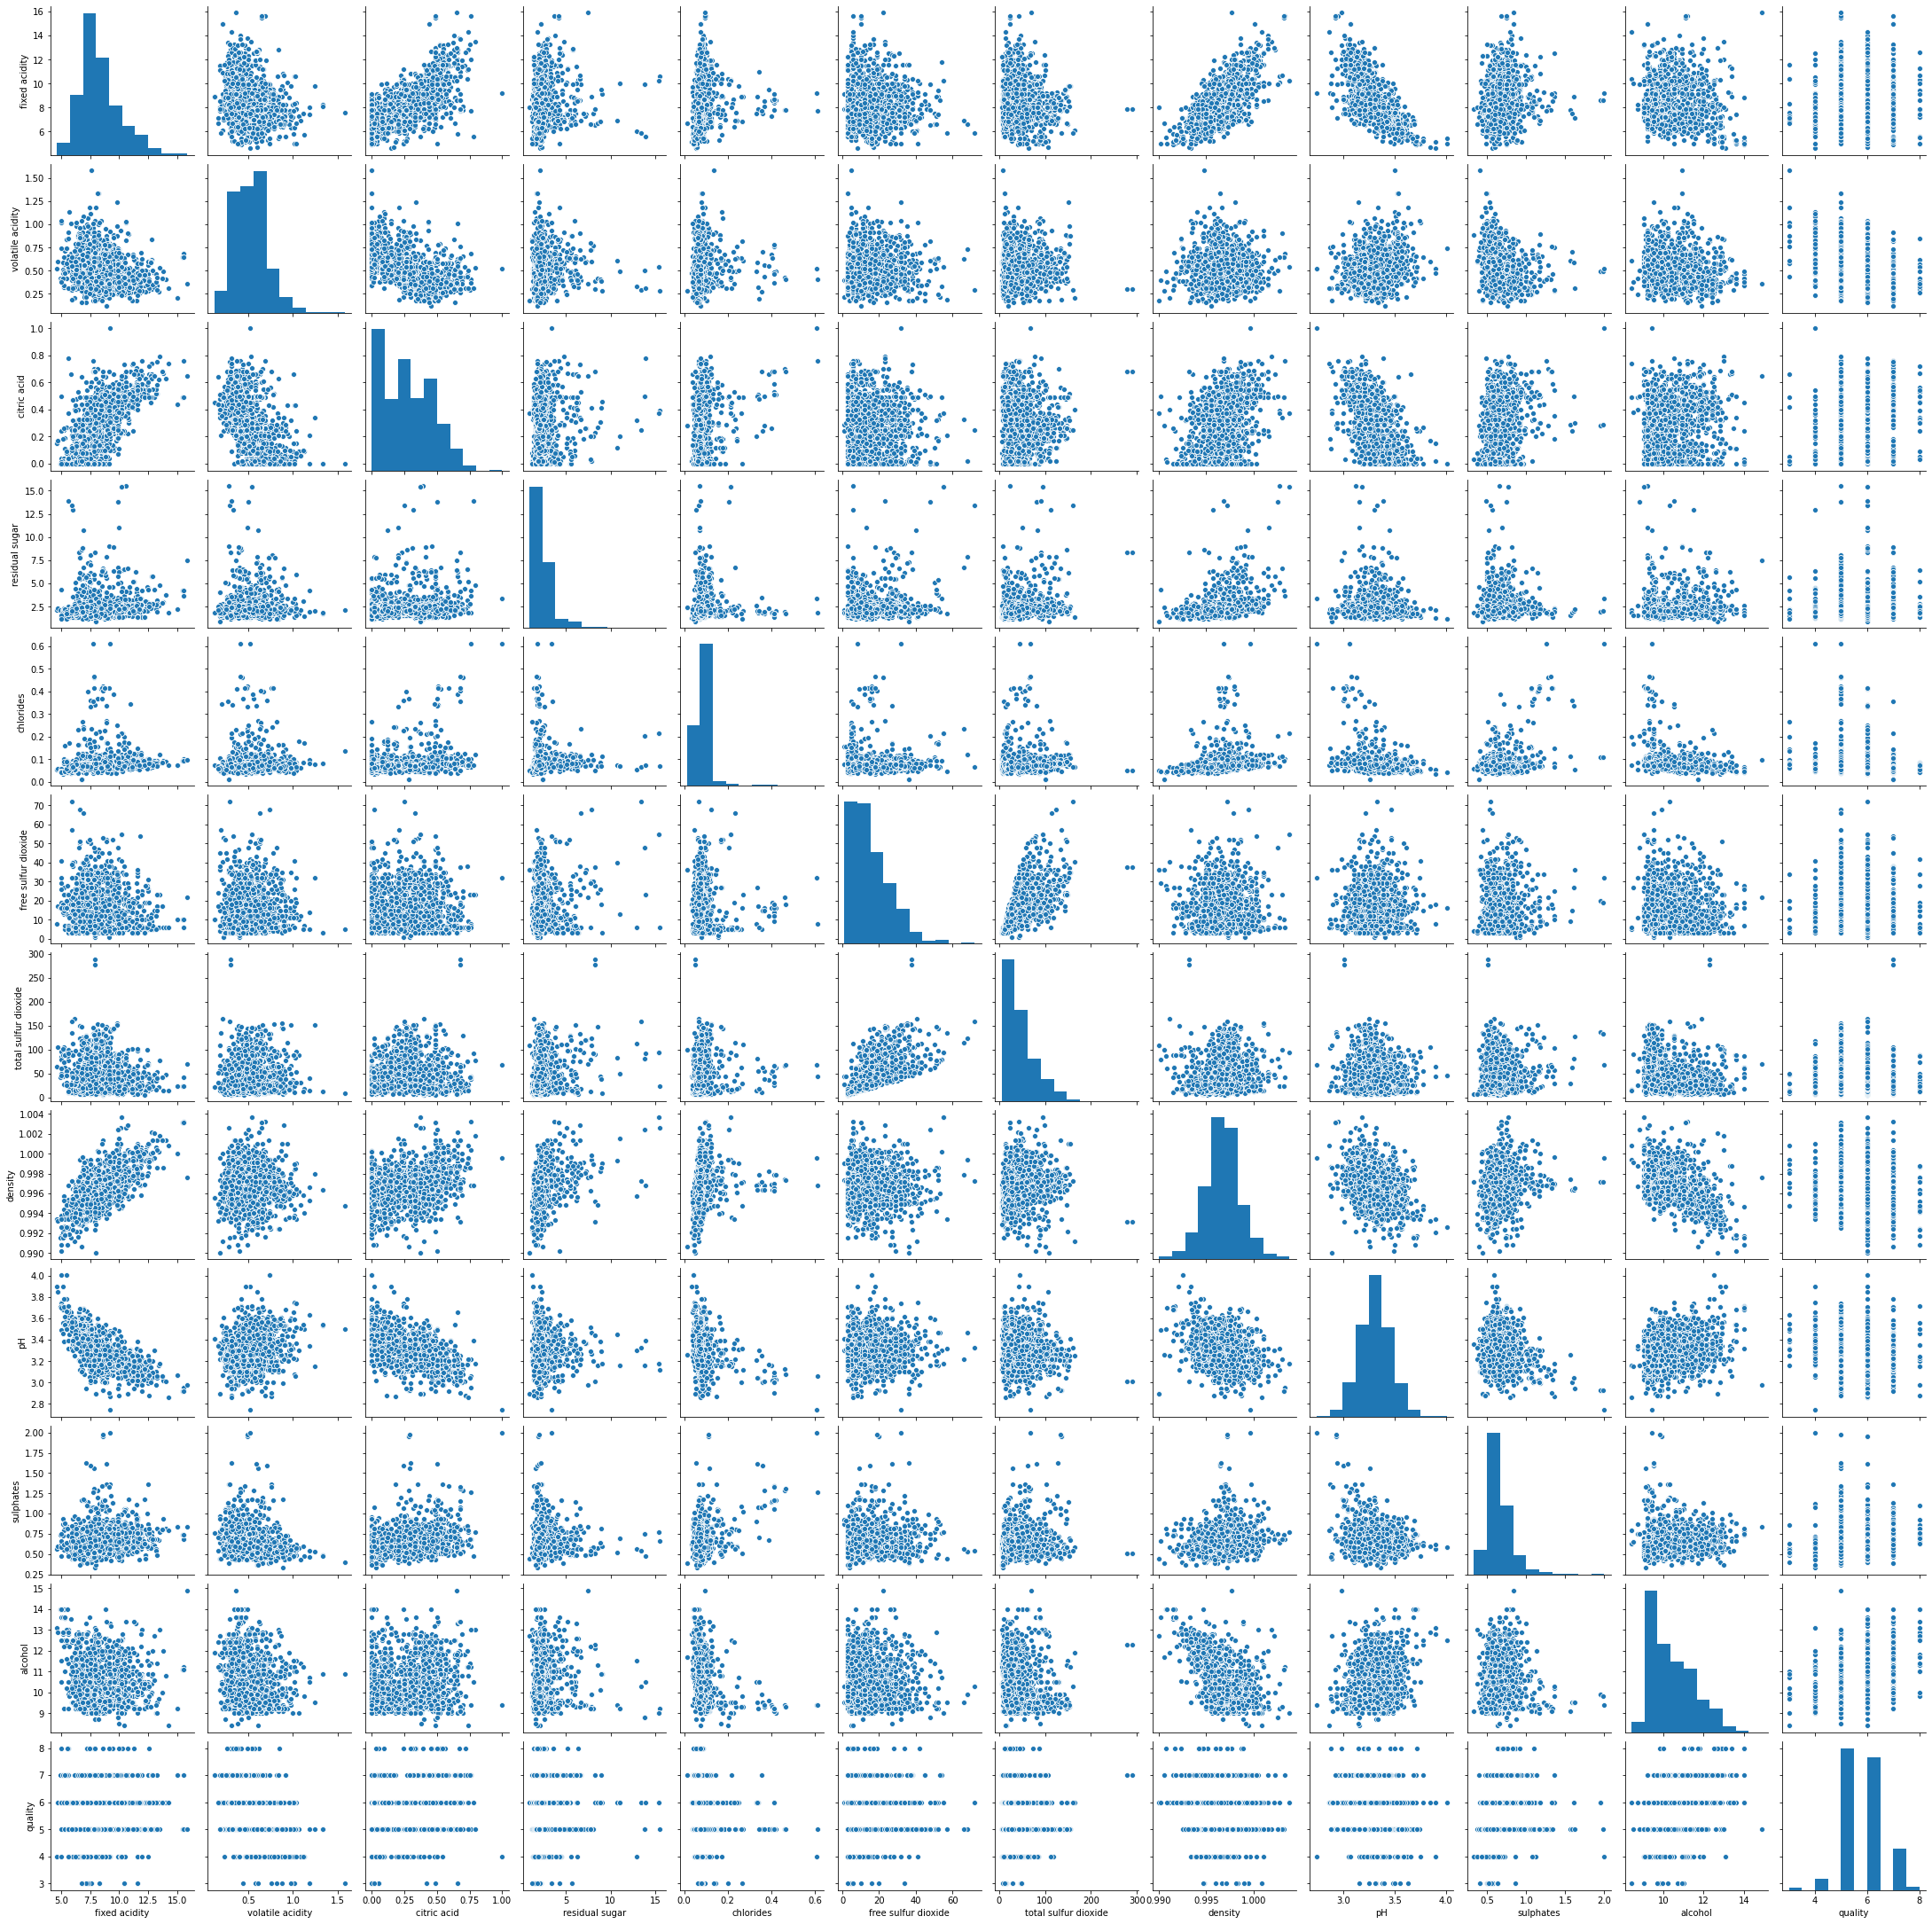

In [0]:
sns.pairplot(df)

# Data Prep

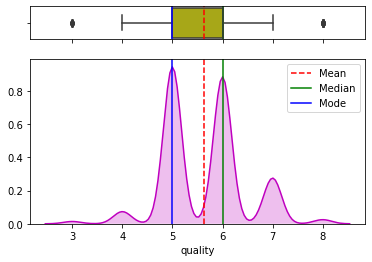

In [0]:
mean = df["quality"].mean()
median = df["quality"].median()
mode = df["quality"].mode()[0]

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})

sns.boxplot(df["quality"], ax=ax_box, color="y", width=10)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.distplot(df["quality"], ax=ax_hist, hist=False, color="m", kde_kws={"shade": True})
ax_hist.axvline(mean, color='r', linestyle='--')
ax_hist.axvline(median, color='g', linestyle='-')
ax_hist.axvline(mode, color='b', linestyle='-')

plt.legend({'Mean':mean,'Median':median,'Mode':mode})

ax_box.set(xlabel='')
plt.show()

## Group quality to 3 categories

Based on the spread of mean and median, to simplify our problem, we want to divide 0-10 quality scale into 3 rating categories: `low`, `moderate/average` and `high/good` quality. These categories should be more practical for real-world use.

We determine that:
- wine quality of `0 - 4` belongs to `low` rating (label: `0`)
- wine quality of `5 - 6` belongs to `moderate/average` rating (label: `1`)
- wine quality of `>= 7` belongs to `high/good` rating (label: `2`)

In [0]:
# divide quality to rating
# 0 < q < 5: 0; 5 <= q < 7: 1; q >= 7: 2;

df['Rating'] = df['quality'].map(lambda x: 0 if x < 5 else 1 if x < 7 else 2)

df['Rating'].value_counts()

1    1319
2     217
0      63
Name: Rating, dtype: int64

In [0]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [0]:
dataset = df.copy()
dataset.pop("quality")

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

## Create test data

We don't have test data available as is from the source, so we have to create it from the data pool.

We decided to train on 80% of the data, and make the rest 20% as the test data.

To avoid bias, we divide the train and test data with random sampling.

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [0]:
train_dataset

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Rating
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,1
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,1
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,2
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,1
979,12.2,0.450,0.49,1.40,0.075,3.0,6.0,0.99690,3.13,0.63,10.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
281,7.7,0.270,0.68,3.50,0.358,5.0,10.0,0.99720,3.25,1.08,9.9,2
932,7.6,0.400,0.29,1.90,0.078,29.0,66.0,0.99710,3.45,0.59,9.5,1
732,7.3,0.835,0.03,2.10,0.092,10.0,19.0,0.99660,3.39,0.47,9.6,1
715,7.2,0.490,0.18,2.70,0.069,13.0,34.0,0.99670,3.29,0.48,9.2,1


Statistics of the training set.

We will use values from this stats (mean, std) to normalize the data.

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("Rating")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1279.0,8.310164,1.744190,4.60000,7.1000,7.90000,9.250000,15.9000
volatile acidity,1279.0,0.525571,0.176645,0.12000,0.3900,0.52000,0.635000,1.5800
citric acid,1279.0,0.271618,0.196822,0.00000,0.0900,0.26000,0.430000,0.7900
residual sugar,1279.0,2.516341,1.300985,0.90000,1.9000,2.20000,2.600000,13.9000
chlorides,1279.0,0.087347,0.045666,0.01200,0.0710,0.07900,0.091000,0.6110
free sulfur dioxide,1279.0,15.868647,10.438880,1.00000,7.0000,14.00000,21.000000,72.0000
total sulfur dioxide,1279.0,46.488663,32.952841,6.00000,22.0000,38.00000,62.000000,289.0000
density,1279.0,0.996739,0.001888,0.99007,0.9956,0.99676,0.997855,1.0032
pH,1279.0,3.312588,0.153923,2.87000,3.2100,3.31000,3.400000,4.0100
sulphates,1279.0,0.655012,0.160192,0.33000,0.5500,0.62000,0.730000,1.9800


## Separate label and features

In [0]:
train_labels = train_dataset.pop('Rating')
test_labels = test_dataset.pop('Rating')

## Normalize values

On our attempt to see our dataset characteristics earlier, we see that range of the data varies.

For example, values of `fixed acidity` ranges from `4.6 - 15.9`, while `total sulfur dioxide` has a range of `6 - 62`. Meanwhile, `pH` values only range from `2.74` to `4.01`.

That this can cause  issues when training the model. Therefore, we convert each value of the features to its Z-score.

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
normed_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1279.0,-4.041073e-15,1.0,-2.127157,-0.693826,-0.235160,0.538838,4.351497
volatile acidity,1279.0,-4.294063e-15,1.0,-2.295969,-0.767477,-0.031537,0.619488,5.969209
citric acid,1279.0,2.692486e-15,1.0,-1.380020,-0.922754,-0.059030,0.804694,2.633757
residual sugar,1279.0,2.239543e-17,1.0,-1.242398,-0.473750,-0.243155,0.064304,8.750032
chlorides,1279.0,1.270689e-14,1.0,-1.649964,-0.357972,-0.182787,0.079991,11.467036
free sulfur dioxide,1279.0,5.989475e-17,1.0,-1.424353,-0.849578,-0.179008,0.491562,5.377143
total sulfur dioxide,1279.0,-1.035138e-16,1.0,-1.228685,-0.743143,-0.257600,0.470713,7.359345
density,1279.0,1.039239e-12,1.0,-3.532885,-0.603351,0.011163,0.591242,3.422772
pH,1279.0,-2.381585e-14,1.0,-2.875377,-0.666487,-0.016813,0.567893,4.530901
sulphates,1279.0,-5.293307e-16,1.0,-2.028888,-0.655537,-0.218561,0.468115,8.271250


# Define the function that builds model

In [0]:
def build_model(my_learning_rate):
  model = keras.Sequential([
    layers.Flatten(input_shape=[(len(train_dataset.keys()))]),
    layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(3),
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=my_learning_rate)

  model.compile(optimizer=optimizer,
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

# Build and train the model

In [0]:
# Hyperparameters
EPOCHS = 100
learning_rate = 0.001

model = build_model(learning_rate)
print(model.summary())

checkpoint_path = "/content/gdrive/My Drive/Trained_Models/wine_binary_quality/wine_binary_quality.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, 
  validation_split = 0.2, 
  callbacks=[cp_callback],
  )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               1536      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,923
Trainable params: 1,923
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
 1/32 [..............................] - ETA: 0s - loss: 1.3402 - accuracy: 0.0938
Epoch 00001: saving model to /content/gdrive/My Drive/Trained_Models/wine_binary_quality/wine_binary_quality.ckpt
32/32 [==============================]

# Evaluate the model

In [0]:
# Evaluate model with test data

test_loss, test_acc = model.evaluate(normed_test_data, test_labels, verbose=2)
print('Test accuracy:', test_acc)

10/10 - 0s - loss: 0.4552 - accuracy: 0.8687
Test accuracy: 0.8687499761581421


# Export model to GDrive

In [0]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(normed_test_data)

In [0]:
#Graph to look at the full set of 3 class predictions

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Real Value :  2
Predicted Value :  2


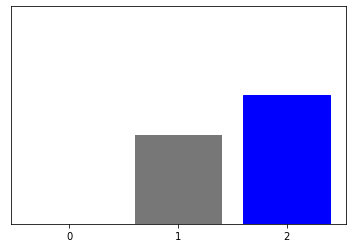

In [0]:
i = len(predictions)-2
array_test_labels = test_labels.to_numpy()

print("Real Value : ", array_test_labels[i])
print("Predicted Value : ", np.argmax(predictions[i]))
plot_value_array(i, predictions[i],  array_test_labels)

In [0]:
new_df = test_labels.copy()

new_df = new_df.reset_index()
del new_df["index"]
prediction_array = []

for prediction in predictions :
  prediction_array.append(np.argmax(prediction))
new_df["Rating Prediction"] = prediction_array

new_df.tail(5)

,Rating,Rating Prediction
315,1,1
316,1,1
317,1,1
318,2,2
319,1,1


In [0]:
checkpoint_path = "/content/gdrive/My Drive/Trained_Models/wine_classifier/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [0]:
model.save_weights('/content/gdrive/My Drive/Trained_Models/wine_classifier/wine_quality_model')

In [0]:
model_save_name = 'wine_classifier'
save_model_path = '/content/gdrive/My Drive/Trained_Models/wine_classifier'

In [0]:
model.save(save_model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Trained_Models/wine_classifier/assets


In [0]:
model.save('/content/gdrive/My Drive/Trained_Models/wine_classifier/wine_classifier.h5') 

In [0]:
converter = tf.lite.TFLiteConverter.from_saved_model(save_model_path)
tflite_model = converter.convert()
open("/content/gdrive/My Drive/Trained_Models/wine_classifier/wine_classifier.tflite", "wb").write(tflite_model)

8760